In [1]:
import numpy as np
from scipy.misc import factorial
import pylab as pl

### Define parameters

In [2]:
Nt = 800 # number of time points
k = 8
dtime = 0.001
buff_len = 10
thr = 0.024 # big T activaiton threshold (this is only a temporary solution)
ev_trh = 0.01 # evidence accumulation threshold

### Create supported dimension

In [3]:
class Support:
    
    def __init__(self, tstr_min=0.1, tstr_max=0.5, buff_len=10, k=8, dtime=0.001):
        self.tstr_min = tstr_min
        self.tstr_max = tstr_max
        self.buff_len = buff_len
        self.k = k
        self.dtime = dtime
        self.len_time = Nt*dtime
        
        self.N = self.buff_len+2*self.k
        self.Nt = int(self.len_time/self.dtime)

        #Create power-law growing Taustarlist and corresponding s
        a = (self.tstr_max/self.tstr_min)**(1./buff_len)-1
        pow_vec = np.arange(-self.k,buff_len + self.k) #-1
        self._Taustarlist = self.tstr_min * (1 + a)**pow_vec

        s = self.k/self._Taustarlist
        
        #Create DerivMatrix
        self._DerivMatrix = np.zeros((self.N,self.N))
        for i in range(1,self.N-1):
            self._DerivMatrix[i, i-1] = -(s[i+1]-s[i])/(s[i]-s[i-1])/(s[i+1] - s[i-1])
            self._DerivMatrix[i, i] = ((s[i+1]-s[i])/(s[i]- s[i-1])-(s[i]-s[i-1])/(s[i+1]-s[i]))/(s[i+1] - s[i-1])
            self._DerivMatrix[i, i+1] = (s[i]-s[i-1])/(s[i+1]-s[i])/(s[i+1] - s[i-1])

        self.t = np.zeros((self.N,self.Nt))
        self.T = np.zeros((self.N,self.Nt))
        self._s = s
        
    def update(self, time_index, f=np.zeros(Nt), alpha = 1):
        self.t[:,time_index] = self.t[:,time_index-1]+alpha*((-self._s.T*self.t[:,time_index-1]+f[time_index])*self.dtime)
        t_diff = np.dot(np.linalg.matrix_power(self._DerivMatrix, self.k), self.t[:,time_index])
        L1 = (-1)**self.k*self._s**(self.k+1) # this can be taken out
        L2 = t_diff/factorial(self.k)
        self.T[:,time_index] = L1.T*L2.T
        self.T[self.T[:,time_index]<0,time_index] = 0 # in case of numerical errors

### Create an input node prototype

In [4]:
class input_node:
    
    def __init__(self, name):
        self.name = name
        self.support = Support()
        self.value = np.zeros(Nt)           

### Define input space

In [5]:
input_names = ['a', 'b', 'c']

#cat = input_node(cat) # basic example

# for each input name create an instance of a class input_name with the name of the input
# all input instances are placed in a list called inputs
inputs = []
for name in input_names:
    inputs.append(input_node(name))

### Create an action node prototype

In [6]:
class input_node:
    
    def __init__(self, name):
        self.name = name
        self.support = Support()
        self.value = np.zeros(Nt) 

### Define action space

In [7]:
action_names = ['attend_to_change', 'diff', 'left', 'right','lick']

actions = []
for name in action_names:
    actions.append(input_node(name))

### Create program class

In [8]:
class program:
    
    def __init__(self):
        pass
    
    class dms:
        def __init__(self):
            
            self.alpha = -1 # default is to run the program
            
        def start(self, time_index, k=8):
            
            s = inputs[0].support._s
                        
            actions[action_names.index('attend_to_change')].support.t[:,time_index-1] = \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+1]*s)
            
            #actions[action_names.index('attend_to_change_2')].support.t[:,time_index-1] = \
            #dtime*np.exp(-inputs[0].support._Taustarlist[k+2]*s)
            
            # normally the two peaks would end up too close to be detectable 
            # so when first peak is detected i decrease it by the impulse response peak amplitude to make second peak
            # detectable
            actions[action_names.index('attend_to_change')].support.t[:,time_index-1] = \
                actions[action_names.index('attend_to_change')].support.t[:,time_index-1] + \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+2]*s)
                        
            actions[action_names.index('diff')].support.t[:,time_index-1] = \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+3]*s)
            
            actions[action_names.index('left')].support.t[:,time_index-1] = \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+4]*s)
            
            actions[action_names.index('right')].support.t[:,time_index-1] = \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+4]*s)
            
            actions[action_names.index('lick')].support.t[:,time_index-1] = \
                dtime*np.exp(-inputs[0].support._Taustarlist[k+5]*s)
        
        def set_alpha(self, alpha):
            self.alpha = alpha

### Describe specific actions

In [9]:
# when action was completed subtract the peak amplitude from small t to avoid running the action again
def finish_action(name):
    s = inputs[0].support._s
    # remove the peak (in case it's more than once)
    actions[action_names.index(name)].support.t[:,time_index] = \
        actions[action_names.index(name)].support.t[:,time_index] - \
        dtime*np.exp(-(inputs[0].support._Taustarlist[k]-dtime)*s*(k+1)/k)
    # zero negative to avoid num error
    actions[action_names.index(name)].support.t[\
        actions[action_names.index(name)].support.t[:,time_index]<0,time_index] = 0 
    #actions[action_names.index('attend_to_change')].support.t[:,time_index] = np.zeros(buff_len+2*k)
    
# scan through the input space and find a change
# for the moment this just tests if there is a non-zero input
def attend_to_change():
    # pause the program since no input
    dms.set_alpha(0)
    change = 0
    for name in input_names:
        if inputs[input_names.index(name)].value[time_index] > 0:
            # stop decay of the input neuron
            #inputs[input_names.index(name)].support.alpha = 0
            #dms.set_alpha(-10)
            #update_program_memory(dms.alpha)
            # move the program forward (technically backward)
            dms.set_alpha(-1)
            change = 1
            finish_action('attend_to_change')
    if not change: # if no change was found keep this node active
        actions[action_names.index('attend_to_change')].value[time_index+1] = 1.

# initialize memory scanner        
def scanner_init():
    scanner = Support()
    f_tmp = np.zeros(Nt)
    f_tmp[0] = 1
    scanner.update(0, f_tmp)
    return scanner

# scans memory along target input node at i-th time step in the past 
def scan(scanner, target, i):
    return sum(scanner.T[k:-k,i]*inputs[input_names.index(target)].support.T[k:-k,time_index])

# initialize evidence accumulator
def ev_acc_init():
    # evidence accumulators
    global evidence_l, evidence_r
    evidence_l = Support()
    evidence_r = Support()
    f_tmp = np.zeros(Nt)
    f_tmp[0] = 1
    evidence_l.update(0, f_tmp)
    evidence_r.update(0, f_tmp)
    return evidence_l, evidence_r

# accumulate evidence
def ev_acc(evidence_l, evidence_r, ev_acc_time, alpha_l=0, alpha_r=0):
    global ev_left, ev_right
    if alpha_l > 0:
        evidence_l.update(ev_acc_time, np.zeros(Nt), alpha_l*1000)
        if evidence_l.T[k+5, ev_acc_time] > ev_trh:
            ev_left = 1
    if alpha_r > 0:
        evidence_r.update(ev_acc_time, np.zeros(Nt), alpha_r*1000)
        if evidence_r.T[k+5, ev_acc_time] > ev_trh:
            ev_right = 1
        
# compare currently present stimulus with the next most recent stimulus            
def diff():
    dms.set_alpha(0)
    # initialize evidence accumulation
    evidence_l, evidence_r = ev_acc_init()
    # find stimulus that was just presented (looking into small t because it's no longer in f and big T did not 
    # peak at first taustar yet)
    max_val = 0
    for name in input_names:
        if sum(inputs[input_names.index(name)].support.t[:,time_index]) > max_val:
            target = name
            max_val = sum(inputs[input_names.index(name)].support.t[:,time_index])
    # now we need to scan the memory to find if previous stimulus was same or differet
    scanner = scanner_init()
    # scan trhough all taustars and send the output to evidence accumulator
    limit = int((scanner.tstr_max-scanner.tstr_min)/dtime)
    for i in range(limit):
        for name in input_names:
            ev = scan(scanner, name, i)
            if name == target:
                ev_acc(evidence_l, evidence_r, i+1, alpha_l = ev, alpha_r = 0)
            else:
                ev_acc(evidence_l, evidence_r, i+1, alpha_l = 0, alpha_r = ev)
        scanner.update(i+1)
    dms.set_alpha(-1)
    finish_action('diff')
    
                
def left():
    if not ev_left:
        actions[action_names.index('left')].value[time_index] = 0
    finish_action('left')

def right():
    if not ev_right:
        actions[action_names.index('right')].value[time_index] = 0
    finish_action('right')

def lick():
    finish_action('lick')
    

### Update memory at every time step

In [10]:
def update_input_memory():
    for name in input_names:
        inputs[input_names.index(name)].support.update(time_index, inputs[input_names.index(name)].value)
    
def update_program_memory(alpha):    
    for name in action_names:
        actions[action_names.index(name)].support.update(time_index, np.zeros(Nt), alpha)
        
def check_program_memory():
    for name in action_names:
        #if(actions[action_names.index(name)].support.T[k,time_index] >= thr): # if reached a peak
        if(actions[action_names.index(name)].support.T[k,time_index-1] > \
           actions[action_names.index(name)].support.T[k,time_index-2] and \
           actions[action_names.index(name)].support.T[k,time_index] < \
           actions[action_names.index(name)].support.T[k,time_index-1]): # if reached a peak
            print time_index
            print name
            actions[action_names.index(name)].value[time_index] = 1. # made the corresponding action node active
        if actions[action_names.index(name)].value[time_index]: # it was either a peak or it was active from before
            eval(name+'()') # call the function that nodes is connected with 
                            # this could be solved in a more elegant way if action_names is a dictionary 

### Plot stuff

In [11]:
%matplotlib inline
#%matplotlib notebook
pl.ion()

def plot_inputs():
    for idx, name in enumerate(input_names):
        _ = pl.subplot(len(input_names), 1, idx+1)
        _ = pl.plot(inputs[input_names.index(name)].value, color='blue')
        
def plot_memory():
    k = inputs[0].support.k
    for idx, name in enumerate(input_names):
        _ = pl.subplot(len(input_names), 1, idx+1)
        #_ = pl.scatter(time_index, inputs[input_names.index(name)].support.T[k:-k,time_index], color='blue')
        _ = pl.plot(inputs[input_names.index(name)].support.T[k:-k,:].T, color='blue')
        
        
def plot_inputs_memory():
    fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    k = inputs[0].support.k
    for idx, name in enumerate(input_names):
        ax = pl.subplot(3, len(input_names), idx+1)
        ax.set_title(input_names[idx])
        ax.plot(inputs[input_names.index(name)].value, color='blue')
        ax = pl.subplot(3, len(input_names), idx+1+len(input_names))
        ax.plot(inputs[input_names.index(name)].support.t[k:-k,:].T, color='blue')
        ax = pl.subplot(3, len(input_names), idx+1+2*len(input_names))
        ax.plot(inputs[input_names.index(name)].support.T[k:-k,:].T, color='blue')
        
def plot_actions_memory():
    fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    k = inputs[0].support.k
    for idx, name in enumerate(action_names):
        ax = pl.subplot(3, len(action_names), idx+1)
        ax.set_title(action_names[idx])
        ax.plot(actions[action_names.index(name)].value, color='blue')
        ax = pl.subplot(3, len(action_names), idx+1+len(action_names))
        ax.plot(actions[action_names.index(name)].support.t[k:-k,:].T, color='blue')
        ax = pl.subplot(3, len(action_names), idx+1+2*len(action_names))
        ax.plot(actions[action_names.index(name)].support.T[k:-k,:].T, color='blue')

### Simulate an experiment

In [12]:
# initialize 

Ns = len(inputs) # size of the input space

dms = program.dms()

# initialize evidence accumulation
ev_left = 0
ev_right = 0

#fig1 = pl.figure()
#ax1 = fig1.add_subplot(111)
#ax1.hold(True)
#ax1.plot(x, y)

pl.tight_layout()

# zero all inputs
#for name in input_names:
#    inputs[input_names.index(name)].value = np.zeros(Nt)

for time_index in range(Nt-1):
    # add some inputs
    if(time_index == 100): # for test purposes this is hard coded
        dms.start(time_index) 
    if(time_index == 300):
        inputs[input_names.index('b')].value[time_index] = 1
    if(time_index == 500):
        inputs[input_names.index('b')].value[time_index] = 1
    # make memory decay for one time step
    update_input_memory()
    update_program_memory(dms.alpha)
    # check if program memory activates node - since it runs backwards
    check_program_memory()

101
attend_to_change
308
attend_to_change
518
diff
546
left
546
right
580
lick


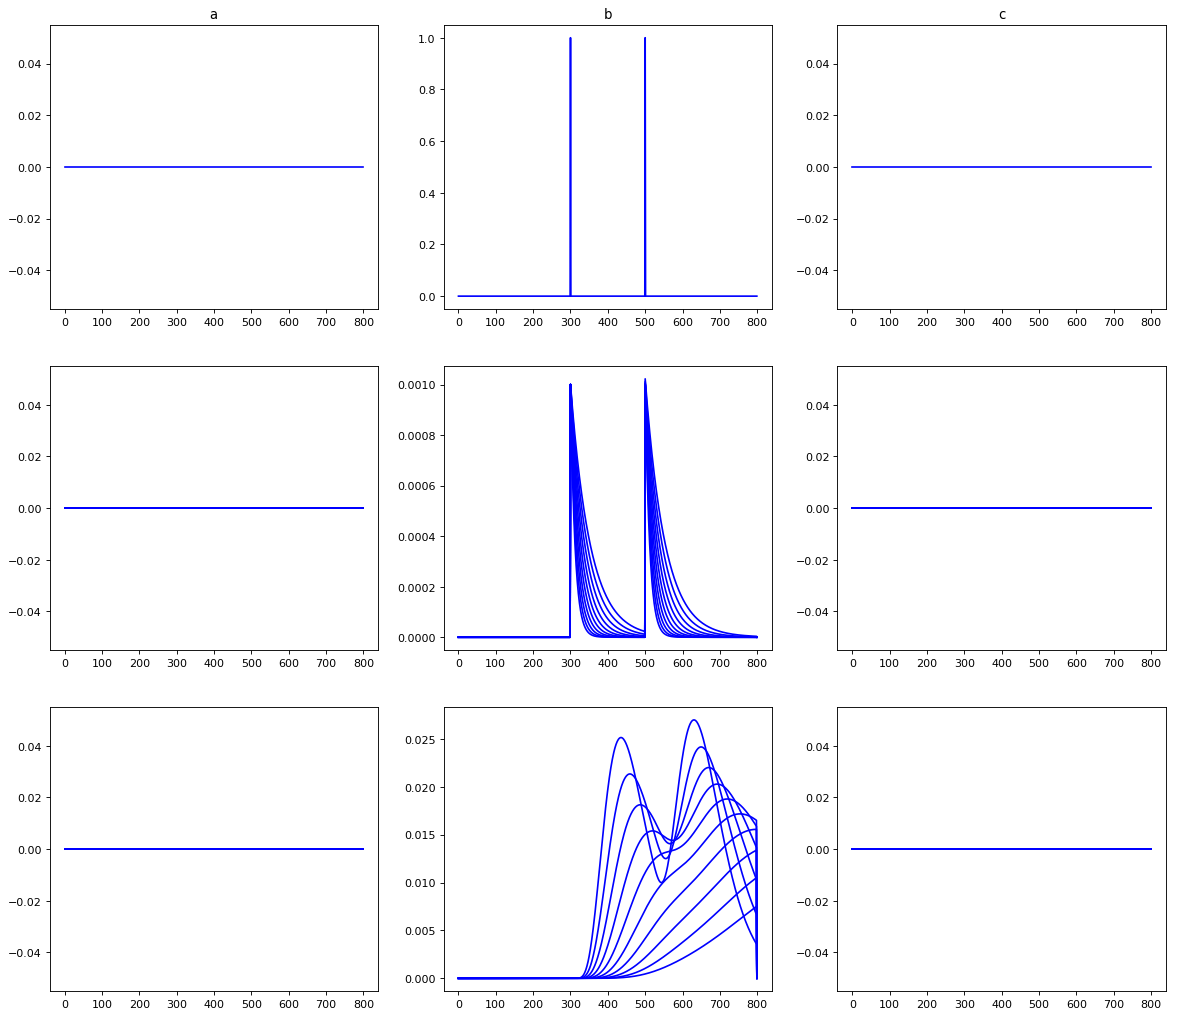

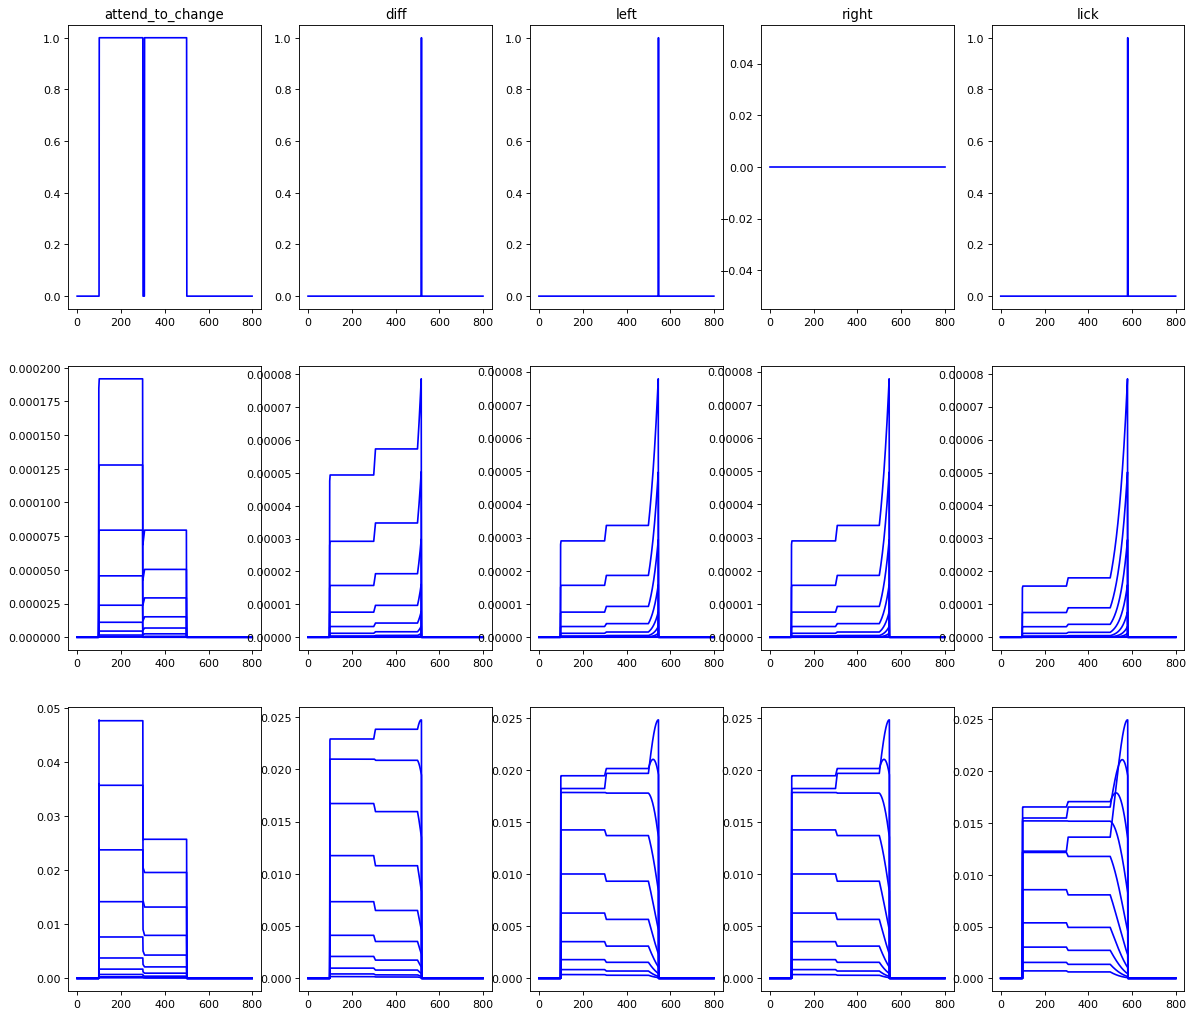

In [13]:
plot_inputs_memory()
plot_actions_memory()

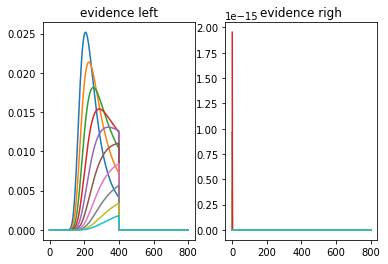

In [14]:
ax = pl.subplot(1,2,1)
_ = ax.plot(evidence_l.T[k:-k,:].T)
_ =ax.set_title('evidence left')
ax = pl.subplot(1,2,2)
_ = ax.plot(evidence_r.T[k:-k,:].T)
_ = ax.set_title('evidence righ')

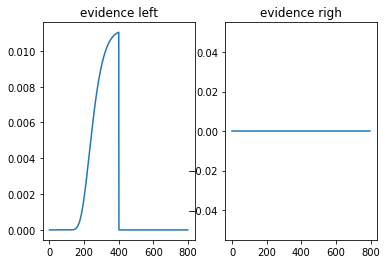

In [15]:
ax = pl.subplot(1,2,1)
_ = ax.plot(evidence_l.T[k+5,:].T)
_ =ax.set_title('evidence left')
ax = pl.subplot(1,2,2)
_ = ax.plot(evidence_r.T[k+5,:].T)
_ = ax.set_title('evidence righ')